## import libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision import models
import copy
from torch.autograd import Function
import os
import pandas as pd
import permute
from sklearn.model_selection import train_test_split

### Check for GPU

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Import Data

In [3]:
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor()
    ])
train_set = datasets.ImageFolder("../model_training/data_mining/image", transform = transform)

### Defining Parameters

In [4]:
num_classes = 139
batch_size = 16

### Dataloader

In [5]:
trainloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
#testloader = torch.utils.data.DataLoader(datasets['test'],batch_size=batch_size,shuffle=True)

### Visualization

In [6]:
def imshow(img):
    plt.imshow(np.transpose(img, (1, 2, 0)))

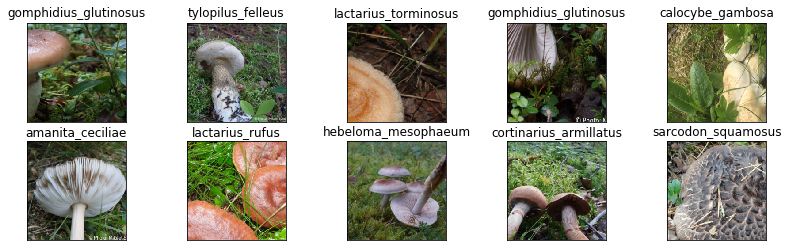

In [7]:
classes = train_set.classes
    
data_iter = iter(trainloader)
images, labels = data_iter.next()
images = images.numpy() 

fig = plt.figure(figsize=(10, 4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    label = labels[idx]
    ax.set_title(classes[label])
plt.subplots_adjust(right = 1.2) 

In [8]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return (100 * correct / total)

### Model Structure

In [9]:
vgg = models.vgg16_bn(pretrained=True)
for param in vgg.parameters():
    param.requires_grad = False

final_in_features = vgg.classifier[6].in_features
vgg.classifier[6] = nn.Linear(final_in_features, num_classes)
for param in vgg.parameters():
    if param.requires_grad:
        print(param.shape)

torch.Size([139, 4096])
torch.Size([139])


In [10]:
vgg = vgg.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(vgg.parameters(),lr=0.01)

In [11]:
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

### Training Steps

In [12]:
%%time

loss_epoch_arr = []
max_epochs = 10

min_loss = 10000000

n_iters = np.ceil(5300/batch_size)

for epoch in range(max_epochs):

    for i, data in enumerate(trainloader, 0):

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        opt.zero_grad()

        outputs = vgg(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        opt.step()
        
        if min_loss > loss.item():
            min_loss = loss.item()
            best_model = copy.deepcopy(vgg.state_dict())
            print('Min loss %0.2f' % min_loss)
        
        if i % 100 == 0:
            print('Iteration: %d/%d, Loss: %0.2f' % (i, n_iters, loss.item()))
            
        del inputs, labels, outputs
        torch.cuda.empty_cache()
        
    loss_epoch_arr.append(loss.item())

vgg.load_state_dict(best_model)
print(evaluation(trainloader, vgg))

Min loss 4.90
Iteration: 0/332, Loss: 4.90
Min loss 4.58
Iteration: 0/332, Loss: 4.58
Min loss 4.06
Min loss 3.72
Min loss 2.94
Min loss 2.36
Min loss 2.27
Iteration: 0/332, Loss: 3.59
Min loss 2.15
Min loss 2.14
Iteration: 0/332, Loss: 3.60
Min loss 1.48
Min loss 1.28
Iteration: 0/332, Loss: 4.12
Min loss 1.01
Iteration: 0/332, Loss: 4.12
Iteration: 0/332, Loss: 1.82
Min loss 0.46
Iteration: 0/332, Loss: 2.40
Iteration: 0/332, Loss: 3.06
Min loss 0.22
Iteration: 0/332, Loss: 2.23
66.66666666666667
Wall time: 3min 8s


In [ ]:
print("Acc on training set is {} and test set is {}".format(evaluation(trainloader, vgg),evaluation(testloader, vgg)))

In [13]:
print(evaluation(trainloader, vgg))

72.40829346092504


In [14]:
torch.save(vgg.state_dict(), os.path.join("../model_training","model.pth"))

In [ ]:
model = models.vgg16_bn(pretrained=True)
final_in_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(final_in_features, num_classes)

model.load_state_dict(torch.load("../model_training/model.pth"))
model.eval()
model = model.to(device)